In [1]:
from pathlib import Path
import numpy as np
import torch
from owkin.dataset import build_dataset

In [2]:
data_dir = Path("data")
X_train, _, y_train, X_val, _, y_val, X_test, _, df_test = build_dataset(data_dir)

In [3]:
X_train.shape

(276, 1000, 2048)

In [4]:
i = 3
j = 5

from scipy.spatial.distance import cdist

dist = cdist(X_train[i], X_train[j])
print(dist.shape)

(1000, 1000)


In [5]:
%%time
dist = cdist(X_train[i], X_train[j])

CPU times: total: 1.84 s
Wall time: 1.88 s


In [7]:
bags = X_train[:10].copy()

In [8]:
from tqdm import tqdm

def hausdorf_min_max(bag1, bag2):
    dist = cdist(X_train[i], X_train[j])
    return dist.min(), dist.max()

n = bags.shape[0]
hausdorf_distance = np.zeros((n, n, 2))

for i in tqdm(range(n)):
    for j in tqdm(range(i, n)):
        dist = hausdorf_min_max(bags[i], bags[j])
        hausdorf_distance[i, j] = dist
        hausdorf_distance[j, i] = dist

100%|██████████| 10/10 [01:42<00:00, 10.26s/it]


In [6]:
from numba import njit, jit

def hausdorf_matrix_einsum(bags):
    n = bags.shape[0]
    hausdorf = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            dist = np.einsum('ij,ij->i', bags[i], bags[i])[:,None] + np.einsum('ij,ij->i', bags[j], bags[j]) - 2 * np.dot(bags[i], bags[j].T)
            dist = dist.min()
            hausdorf[i, j] = dist
            hausdorf[j, i] = dist
    return hausdorf

def hausdorf_matrix_dot(bags):
    n = bags.shape[0]
    hausdorf = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            dist = (bags[i] * bags[i]).sum(axis=-1)[:, None] + (bags[j] * bags[j]).sum(axis=-1)[None, :] - 2 * np.dot(bags[i], bags[j].T)
            dist_min = dist.min()
            hausdorf[i, j] = dist_min
            hausdorf[j, i] = dist_min
    return hausdorf

@njit
def hausdorf_matrix_jit(bags):
    n, m, _ = bags.shape
    hausdorf = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            dist = (bags[i] * bags[i]).sum(axis=-1).repeat(m).reshape(m, m) + (bags[j] * bags[j]).sum(axis=-1).repeat(m).reshape(m, m).transpose() - 2 * np.dot(bags[i], bags[j].T)
            dist_min = dist.min()
            hausdorf[i, j] = dist_min
            hausdorf[j, i] = dist_min
    return hausdorf


In [107]:
n, m, _ = bags.shape
dist1 = np.einsum('ij,ij->i', bags[i], bags[i])[:,None] + np.einsum('ij,ij->i', bags[j], bags[j]) - 2 * np.dot(bags[i], bags[j].T)
dist2 = (bags[i] * bags[i]).sum(axis=-1)[:, None] + (bags[j] * bags[j]).sum(axis=-1)[None, :] - 2 * np.dot(bags[i], bags[j].T)
dist3 = (bags[i] * bags[i]).sum(axis=-1).repeat(m).reshape(m, m) + (bags[j] * bags[j]).sum(axis=-1).repeat(m).reshape(m, m).transpose() - 2 * np.dot(bags[i], bags[j].T)
                
np.abs(dist1 - dist3).max()

3.8146973e-05

In [108]:
%time _ = hausdorf_matrix_einsum(bags)
%time _ = hausdorf_matrix_dot(bags)
%time _ = hausdorf_matrix_jit(bags)

CPU times: total: 13.9 s
Wall time: 3.17 s
CPU times: total: 14.3 s
Wall time: 4.33 s
CPU times: total: 20.4 s
Wall time: 9.52 s


In [110]:
n_sample_train = 50
hausdorf_matrix_train = hausdorf_matrix_einsum(X_train[:n_sample_train])
hausdorf_matrix_train[hausdorf_matrix_train < 0] = 0

In [118]:
from sklearn.neighbors import KNeighborsClassifier

n_sample = 50
n_neighbors = 5
classifier = KNeighborsClassifier(n_neighbors=n_neighbors, metric="precomputed")
classifier.fit(hausdorf_matrix_train, y_train[:n_sample_train])

KNeighborsClassifier(metric='precomputed')

In [7]:
def hausdorf_matrix(bags_pred, bags_train):
    n = bags_pred.shape[0]
    m = bags_train.shape[0]
    hausdorf = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            dist = np.einsum('ij,ij->i', bags_pred[i], bags_pred[i])[:,None] + np.einsum('ij,ij->i', bags_train[j], bags_train[j]) - 2 * np.dot(bags_pred[i], bags_train[j].T)
            dist = dist.min()
            hausdorf[i, j] = dist
    return hausdorf

In [130]:
n_sample_val = 50
hausdorf_matrix_pred = hausdorf_matrix(X_val[:n_sample_val], X_train[:n_sample_train])
hausdorf_matrix_pred[hausdorf_matrix_pred < 0] = 0

In [154]:
y_pred = classifier.predict_proba(hausdorf_matrix_pred)

from sklearn.metrics import roc_auc_score
roc_auc_score(y_val[:n_sample_val], y_pred[:, 1])

0.6871657754010695

# Train

In [8]:
from sklearn.neighbors import KNeighborsClassifier

hausdorf_matrix_train = hausdorf_matrix_einsum(X_train)
hausdorf_matrix_train[hausdorf_matrix_train < 0] = 0

Train


KNeighborsClassifier(metric='precomputed')

In [ ]:
hausdorf_matrix_pred = hausdorf_matrix(X_val, X_train)
hausdorf_matrix_pred[hausdorf_matrix_pred < 0] = 0

In [31]:
from sklearn.metrics import roc_auc_score
n_neighbors = np.arange(1, 50)
roc_auc = np.zeros_like(n_neighbors, dtype=float)
roc_auc_weight = np.zeros_like(n_neighbors, dtype=float)

for n_neighbor in n_neighbors: 
    classifier = KNeighborsClassifier(n_neighbors=n_neighbor, metric="precomputed")
    classifier.fit(hausdorf_matrix_train, y_train)
    y_pred = classifier.predict_proba(hausdorf_matrix_pred)
    roc_auc[n_neighbor - 1] = roc_auc_score(y_val, y_pred[:, 1])

    classifier = KNeighborsClassifier(n_neighbors=n_neighbor, metric="precomputed", weights="distance")
    classifier.fit(hausdorf_matrix_train, y_train)
    y_pred = classifier.predict_proba(hausdorf_matrix_pred)
    roc_auc_weight[n_neighbor - 1] = roc_auc_score(y_val, y_pred[:, 1])

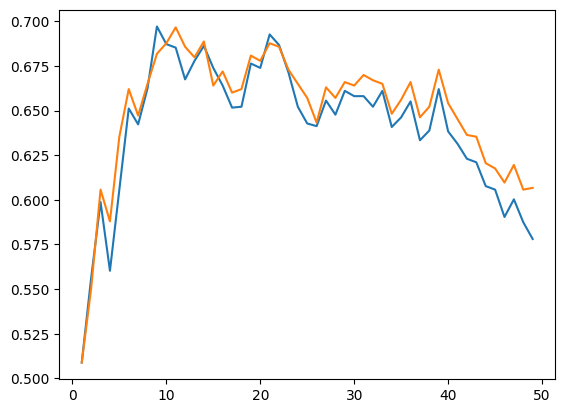

In [32]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(n_neighbors, roc_auc)
plt.plot(n_neighbors, roc_auc_weight)
plt.show()

In [33]:
print(roc_auc.argmax(), roc_auc.max())
print(roc_auc_weight.argmax(), roc_auc_weight.max())

8 0.6971343873517787
10 0.6966403162055337


In [44]:
hausdorf_matrix_val = hausdorf_matrix_einsum(X_val)
hausdorf_matrix_val[hausdorf_matrix_val < 0] = 0

In [48]:
n = X_train.shape[0]
m = X_val.shape[0]
hausdorf_matrix_all = np.zeros((n + m, n + m))
hausdorf_matrix_all[:n, :n] = hausdorf_matrix_train
hausdorf_matrix_all[n:, n:] = hausdorf_matrix_val
hausdorf_matrix_all[:n, n:] = hausdorf_matrix_pred.T
hausdorf_matrix_all[n:, :n] = hausdorf_matrix_pred


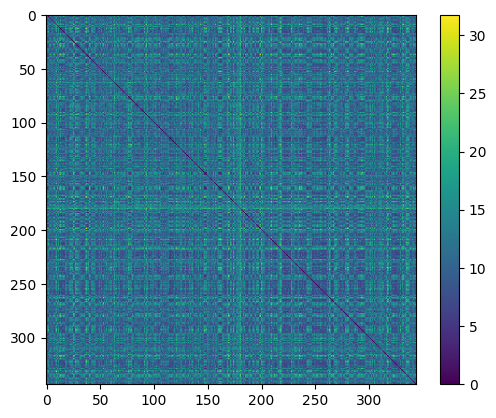

In [51]:
plt.figure()
plt.imshow(hausdorf_matrix_all)
plt.colorbar()
plt.show()

In [52]:
np.save('hausdorf_X_train', hausdorf_matrix_train)
np.save('hausdorf_X_val_train', hausdorf_matrix_pred)
np.save('hausdorf_X_all', hausdorf_matrix_all)

In [53]:
hausdorf_matrix_test = hausdorf_matrix(X_test, X)
hausdorf_matrix_test[hausdorf_matrix_test < 0] = 0

In [54]:
np.save('hausdorf_X_test_all', hausdorf_matrix_test)

In [58]:
y = np.concatenate((y_train, y_val))
y.shape

(344,)

In [80]:
classifier = KNeighborsClassifier(n_neighbors=10, metric="precomputed", weights='distance')
classifier.fit(hausdorf_matrix_all, y)
y_pred = classifier.predict_proba(hausdorf_matrix_test)

In [81]:
import pandas as pd
submission = pd.DataFrame(
        {"Sample ID": df_test["Sample ID"].values, "Target": y_pred[:, 1]}
    ).sort_values(
        "Sample ID"
    )  # extra step to sort the sample IDs

In [82]:
submission.to_csv("knn-hausdorf-min-k=10-distance.csv", index=None)